# NOCD

In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from tqdm import tqdm
%matplotlib inline

from components.utils import load_edgelist_graph,load_ordered_adjlist_graph
from components.evaluation import modularity, symmetric_matrix_modularity

torch.set_default_tensor_type(torch.cuda.FloatTensor)

## 1、Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `np.ndarray` of size `[N, D]`

In [2]:
name = 'bio72'
graph_type = 'merged'

graph_adjlist_path  =  './graphs_' + graph_type + '/' + name + '.adjlist'
graph_edgelist_path =  './graphs_' + graph_type + '/' + name + '.edgelist'
X_path = './features/' + name + '.txt'
X = np.loadtxt( X_path, dtype=float)
G_nx = load_ordered_adjlist_graph( graph_adjlist_path )
A = load_edgelist_graph(graph_edgelist_path)
N, D = X.shape
print('x shape:{} * {}'.format(N, D))

100%|██████████| 968659/968659 [00:06<00:00, 146709.23it/s]


G nodes 25023,edges 993682 with self-loops read already
x shape:25023 * 72


### Hyperparameters 

In [3]:
n_clusters = 8
hidden_sizes = [ ]                  # hidden sizes of the GNN
weight_decay = 1e-2                   # strength of L2 regularization on GNN weights
dropout = 0.5                         # whether to use dropout
batch_norm = True                     # whether to use batch norm
lr = 1e-3                             # learning rate
max_epochs = 1000                     # number of epochs to train
display_step = 25                     # how often to compute validation loss
balance_loss = True                   # whether to use balanced loss
stochastic_loss = True                # whether to use stochastic or full-batch training
batch_size = 20000                    # batch size (only for stochastic training)

Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

In [4]:
cuda = torch.cuda.is_available()
device = torch.device( "cuda" if cuda else "cpu")
print("use cuda: {}".format( cuda))

x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = torch.Tensor(x_norm).cuda().to(torch.float32)

use cuda: True


Define the GNN model

In [5]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, n_clusters, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

Training loop

In [6]:
print('train begin time:{}'.format(time.asctime(time.localtime(time.time()))))  
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

x_display_epochs, val_full_loss_list, x_train_epochs, train_loss_list = [],[],[],[]
it = iter( sampler )
for epoch in tqdm( range( max_epochs+1 ) ):
    batch = next(it)
    if epoch % display_step == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            x_display_epochs.append( epoch )
            val_full_loss_list.append( val_loss )
            # print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f} ')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                stop_epoch = max_epochs
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    x_train_epochs.append( epoch )
    train_loss_list.append( loss )
    loss.backward()
    opt.step()
print(gnn)
for i in range(len( x_display_epochs )):
    print('epoch {:4d},full_loss:{:6f}'.format( x_display_epochs[i], 
        val_full_loss_list[i] ) )
print('train end time:{}'.format(time.asctime(time.localtime(time.time()))))  

train begin time:Mon Apr 26 19:50:41 2021


100%|██████████| 1001/1001 [00:14<00:00, 69.60it/s]

GCN(
  (layers): ModuleList(
    (0): GraphConvolution()
  )
)
epoch    0,full_loss:1.592675
epoch   25,full_loss:1.075900
epoch   50,full_loss:0.832064
epoch   75,full_loss:0.742517
epoch  100,full_loss:0.716220
epoch  125,full_loss:0.709356
epoch  150,full_loss:0.707261
epoch  175,full_loss:0.706294
epoch  200,full_loss:0.705595
epoch  225,full_loss:0.704960
epoch  250,full_loss:0.704377
epoch  275,full_loss:0.703766
epoch  300,full_loss:0.703201
epoch  325,full_loss:0.702632
epoch  350,full_loss:0.702048
epoch  375,full_loss:0.701437
epoch  400,full_loss:0.700779
epoch  425,full_loss:0.700100
epoch  450,full_loss:0.699441
epoch  475,full_loss:0.698749
epoch  500,full_loss:0.697960
epoch  525,full_loss:0.697151
epoch  550,full_loss:0.696406
epoch  575,full_loss:0.695610
epoch  600,full_loss:0.694821
epoch  625,full_loss:0.694016
epoch  650,full_loss:0.693219
epoch  675,full_loss:0.692402
epoch  700,full_loss:0.691621
epoch  725,full_loss:0.690869
epoch  750,full_loss:0.690114
epoch  

## 2、Analyzing the results

Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

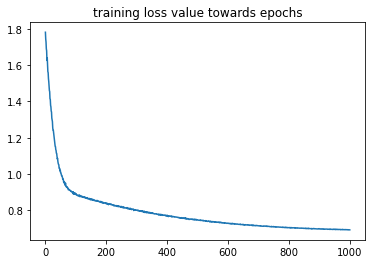

In [7]:
# 损失函数随迭代次数变化
plt.plot(x_train_epochs, train_loss_list, label='train_loss_list')
plt.title('training loss value towards epochs')
plt.show()

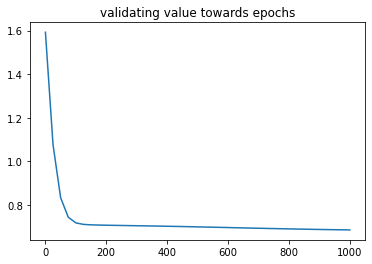

In [8]:
plt.title('validating value towards epochs')
plt.plot(x_display_epochs, val_full_loss_list, label='val_full_loss_list')
plt.show()

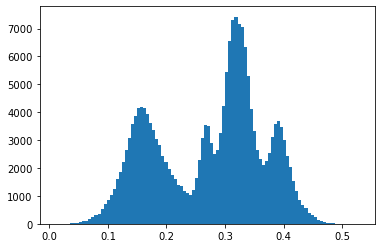

In [9]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

### Visualize the adjacency matrix sorted by the communities

In [10]:
Z_pred = F.relu(gnn(x_norm, adj_norm))
# Z_pred = Z.cpu().detach().numpy() > thresh 
Z_pred = np.argmax(Z_pred.cpu().detach().numpy(), 1)
model_saver.restore()

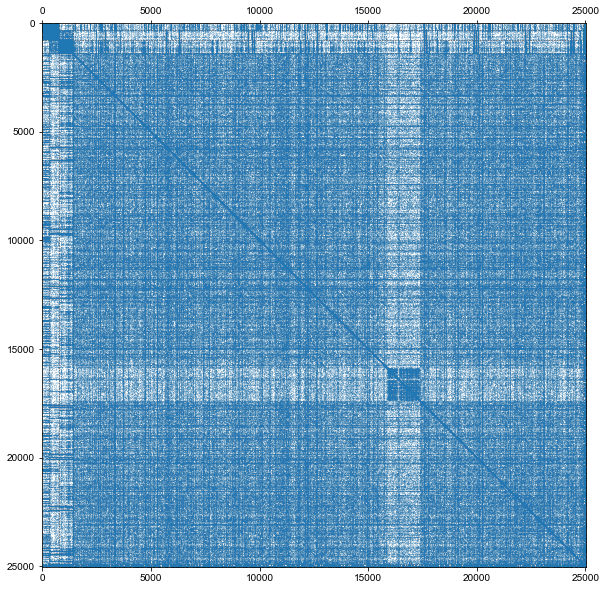

In [11]:
plt.figure(figsize=[10, 10])
# Z_pred = F.relu(gnn(x_norm, adj_norm)).cpu().detach().numpy()
# z = np.argmax(Z_pred, 1)
o = np.argsort(Z_pred)
nocd.utils.plot_sparse_clustered_adjacency(A, n_clusters, Z_pred, o, markersize=0.05)

In [ ]:
print(name)
print(f'\nFinal symmetric_matrix_modularity = {symmetric_matrix_modularity(G_nx, Z_pred):.8f}')  
print('last epoch:{:4d}, full_loss {:6f}'.format( x_display_epochs[-1] ,val_full_loss_list[-1]))

bio72


  1%|          | 250/25023 [00:00<00:09, 2483.08it/s]

number of edges:993682.0
i:233,node_i:233


 79%|███████▉  | 19747/25023 [11:05<05:47, 15.20it/s]

In [ ]:
# Sizes of detected communities
print(Z_pred.sum(0))

### Quantify quality of the communities based on unsupervised metrics.

Metrics:
* **Coverage**: what percentage of the edges is explained by at least one community? (i.e. if $(u, v)$ is an edge, both nodes share at least one community) Higher is better.
$$\textrm{Coverage}(C_1, ..., C_K) = \frac{1}{|E|}\sum_{u, v \in E} \mathbb{1}[z_u^T z_v > 0]$$


* **Density**: average density of the detected communities (weighted by community size). Higher is better.

$$\rho(C) = \frac{\text{# existing edges in $C$}}{\text{# of possible edges in $C$}}$$

$$\textrm{AvgDensity}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \rho(C_i) \cdot |C_i|$$


* **Conductance**: average conductance of the detected communities (weighted by community size). Lower is better.

$$\textrm{outside}(C) = \sum_{u \in C, v \notin C} A_{uv}$$

$$\textrm{inside}(C) = \sum_{u \in C, v \in C, v \ne u} A_{uv}$$

$$\textrm{Conductance}(C) = \frac{\textrm{outside}(C)}{\textrm{inside}(C) + \textrm{outside}(C)}$$

$$\textrm{AvgConductance}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{Conductance}(C_i) \cdot |C_i|$$


* **Clustering coefficient**: average clustering coefficient of the detected communities (weighted by community size). Higher is better.

$$\textrm{ClustCoef}(C) = \frac{\text{# existing triangles in $C$}}{\text{# of possible triangles in $C$}}$$

$$\textrm{AvgClustCoef}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{ClustCoef}(C_i) \cdot |C_i|$$

Clustering coefficient & density of the entire graph

In [ ]:
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')

### Ground truth communities & Predicted communities
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")
The detected partition has lower conductance / higher density / higher clustering coefficient than the GT communities.